# This is my Notebook for the Digital Green Crop Yield Estimate Challenge on Zindi

In [202]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [203]:
# Load files

train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sample_submission = pd.read_csv('SampleSubmission.csv')
var_desc = pd.read_csv('VariableDescription.csv')

In [204]:
pd.set_option('display.max_columns',None)


In [205]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3870 entries, 0 to 3869
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  3870 non-null   object 
 1   District                            3870 non-null   object 
 2   Block                               3870 non-null   object 
 3   CultLand                            3870 non-null   int64  
 4   CropCultLand                        3870 non-null   int64  
 5   LandPreparationMethod               3870 non-null   object 
 6   CropTillageDate                     3870 non-null   object 
 7   CropTillageDepth                    3870 non-null   int64  
 8   CropEstMethod                       3870 non-null   object 
 9   RcNursEstDate                       3787 non-null   object 
 10  SeedingSowingTransplanting          3870 non-null   object 
 11  SeedlingsPerPit                     3581 no

In [206]:
train['TransplantingIrrigationSource'].value_counts()

Boring      3228
Canal        373
Rainfed      103
Pond          36
TubeWell      12
Well           3
Name: TransplantingIrrigationSource, dtype: int64

### Dropping less important columns

In [207]:
X = train.drop(columns=['District','CultLand','CropCultLand','LandPreparationMethod','CropTillageDate','FirstTopDressFert','TransplantingIrrigationHours','RcNursEstDate','OrgFertilizers','Ganaura','CropbasalFerts','SeedingSowingTransplanting','NursDetFactor','TransDetFactor','1appDaysUrea','2appDaysUrea','Harv_date','Threshing_date','Residue_perc','Stubble_use','MineralFertAppMethod.1'])


Xt = test.drop(columns=['District','CultLand','CropCultLand','LandPreparationMethod','CropTillageDate','FirstTopDressFert','TransplantingIrrigationHours','RcNursEstDate','OrgFertilizers','Ganaura','CropbasalFerts','SeedingSowingTransplanting','NursDetFactor','TransDetFactor','1appDaysUrea','2appDaysUrea','Harv_date','Threshing_date','Residue_perc','Stubble_use','MineralFertAppMethod.1'])
Xt

,ID,Block,CropTillageDepth,CropEstMethod,SeedlingsPerPit,TransplantingIrrigationSource,TransplantingIrrigationPowerSource,TransIrriCost,StandingWater,CropOrgFYM,PCropSolidOrgFertAppMethod,NoFertilizerAppln,BasalDAP,BasalUrea,MineralFertAppMethod,1tdUrea,2tdUrea,Harv_method,Harv_hand_rent,Threshing_method,Residue_length,Acre
0,ID_F9XXEXN2ADR2,Khaira,4,Manual_PuddledLine,1.0,Boring,Diesel,200.0,2.0,2.0,SoilApplied,3,6.0,NaN,Broadcasting,8.0,6.0,hand,500.0,hand,22,0.272727
1,ID_SO3VW2X4QO93,Khaira,5,Manual_PuddledRandom,4.0,Canal,NaN,NaN,3.0,NaN,NaN,3,5.0,NaN,Broadcasting,7.0,8.0,hand,150.0,machine,28,0.227273
2,ID_UKUQ7JM8E894,Rajgir,5,Manual_PuddledRandom,2.0,Canal,NaN,NaN,10.0,NaN,Broadcasting,2,9.0,18.0,Broadcasting,9.0,NaN,hand,1200.0,machine,28,0.281250
3,ID_QUISMWEZR2H4,Mahua,5,Manual_PuddledRandom,2.0,Boring,Diesel,NaN,NaN,5.0,SoilApplied,2,15.0,NaN,SoilApplied,9.0,NaN,hand,300.0,hand,30,0.136364
4,ID_25JGI455VKCZ,Rajgir,3,Manual_PuddledRandom,1.0,Boring,Electric,400.0,NaN,NaN,NaN,2,20.0,15.0,Broadcasting,15.0,NaN,machine,NaN,machine,26,0.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,ID_6MMECMX3B728,Khaira,4,Manual_PuddledLine,1.0,Boring,Electric,200.0,2.0,3.0,SoilApplied,3,12.0,NaN,Broadcasting,13.0,12.0,hand,1200.0,hand,23,0.500000
1286,ID_GZ9YGWCLLMKN,Mahua,5,Manual_PuddledRandom,2.0,Boring,Diesel,300.0,2.0,5.0,SoilApplied,1,20.0,NaN,SoilApplied,NaN,NaN,hand,450.0,hand,28,0.181818
1287,ID_01YVA2LJVYBR,Garoul,6,Manual_PuddledLine,1.0,Boring,Electric,200.0,2.0,15.0,SoilApplied,3,6.0,NaN,SoilApplied,6.0,3.0,hand,600.0,hand,29,0.136364
1288,ID_YQRL2IOUU4SZ,Jamui,4,Manual_PuddledRandom,4.0,Boring,Electric,500.0,3.0,NaN,NaN,3,NaN,NaN,Broadcasting,2.0,2.0,hand,90.0,hand,29,0.227273


## Imputation

In [208]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)
columns_knn=['SeedlingsPerPit','TransIrriCost','StandingWater','Harv_hand_rent']

X[columns_knn] = knn_imputer.fit_transform(X[columns_knn])
X.fillna('0', inplace=True)

Xt[columns_knn] = knn_imputer.transform(Xt[columns_knn])
Xt.fillna('0', inplace=True)

In [209]:
X

,ID,Block,CropTillageDepth,CropEstMethod,SeedlingsPerPit,TransplantingIrrigationSource,TransplantingIrrigationPowerSource,TransIrriCost,StandingWater,CropOrgFYM,PCropSolidOrgFertAppMethod,NoFertilizerAppln,BasalDAP,BasalUrea,MineralFertAppMethod,1tdUrea,2tdUrea,Harv_method,Harv_hand_rent,Threshing_method,Residue_length,Acre,Yield
0,ID_GTFAC7PEVWQ9,Noorsarai,5,Manual_PuddledRandom,2.0,Boring,Electric,200.0,2.0,0,0,2,0,20.0,Broadcasting,15.0,0,machine,400.0,machine,30,0.312500,600
1,ID_TK40ARLSPOKS,Rajgir,5,Manual_PuddledRandom,2.0,Boring,Electric,125.0,3.0,0,0,2,15.0,10.0,Broadcasting,20.0,0,hand,3.0,machine,24,0.312500,600
2,ID_1FJY2CRIMLZZ,Gurua,6,Manual_PuddledRandom,2.0,Boring,Electric,80.0,2.0,1.0,SoilApplied,2,4.0,0,SoilApplied,5.0,0,hand,480.0,machine,30,0.148148,225
3,ID_I3IPXS4DB7NE,Gurua,6,Manual_PuddledRandom,2.0,0,0,184.0,2.6,0,SoilApplied,2,6.0,3.0,Broadcasting,5.0,0,hand,240.0,hand,26,0.222222,468
4,ID_4T8YQWXWHB4A,Noorsarai,4,Manual_PuddledRandom,2.0,Boring,Electric,300.0,2.0,0,0,2,15.0,30.0,Broadcasting,30.0,0,machine,187.0,machine,24,0.468750,550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865,ID_7ZZQ6R4XB4FK,Rajgir,6,LineSowingAfterTillage,2.8,Boring,Electric,360.0,5.0,0,SoilApplied,2,18.0,12.0,Broadcasting,12.0,0,machine,650.0,machine,25,0.375000,720
3866,ID_PVVDF6LK6FO8,Mahua,5,Manual_PuddledRandom,1.0,Boring,Diesel,420.0,3.0,0,0,3,6.0,0,RootApplication,6.0,6.0,hand,4.0,hand,30,0.136364,250
3867,ID_RBYVUPRATVMW,Noorsarai,5,Manual_PuddledRandom,1.0,Boring,Electric,120.0,5.0,0,Broadcasting,1,0,24.0,Broadcasting,0,0,hand,1200.0,hand,25,0.375000,600
3868,ID_ARE9QWENJNJ2,Khaira,3,Manual_PuddledRandom,4.0,Canal,0,280.0,9.0,0,0,1,7.0,10.0,Broadcasting,0,0,hand,100.0,hand,25,0.227273,400


## Scaling 

In [210]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numerical_features=['CropTillageDepth','SeedlingsPerPit','TransIrriCost','StandingWater','CropOrgFYM','NoFertilizerAppln','BasalDAP','BasalUrea','1tdUrea','2tdUrea','Harv_hand_rent','Residue_length','Acre']

X[numerical_features] = scaler.fit_transform(X[numerical_features])


Xt[numerical_features] = scaler.transform(Xt[numerical_features])
X

,ID,Block,CropTillageDepth,CropEstMethod,SeedlingsPerPit,TransplantingIrrigationSource,TransplantingIrrigationPowerSource,TransIrriCost,StandingWater,CropOrgFYM,PCropSolidOrgFertAppMethod,NoFertilizerAppln,BasalDAP,BasalUrea,MineralFertAppMethod,1tdUrea,2tdUrea,Harv_method,Harv_hand_rent,Threshing_method,Residue_length,Acre,Yield
0,ID_GTFAC7PEVWQ9,Noorsarai,0.451610,Manual_PuddledRandom,-0.090719,Boring,Electric,-0.414614,-0.562269,-0.096314,0,-0.290751,-1.123597,1.274656,Broadcasting,0.569942,-0.475738,machine,-0.123347,machine,1.090748,0.095092,600
1,ID_TK40ARLSPOKS,Rajgir,0.451610,Manual_PuddledRandom,-0.090719,Boring,Electric,-0.613375,-0.097916,-0.096314,0,-0.290751,0.588250,0.257140,Broadcasting,1.124328,-0.475738,hand,-0.483392,machine,-0.788680,0.095092,600
2,ID_1FJY2CRIMLZZ,Gurua,1.334303,Manual_PuddledRandom,-0.090719,Boring,Electric,-0.732631,-0.562269,-0.090889,SoilApplied,-0.290751,-0.667104,-0.760376,SoilApplied,-0.538828,-0.475738,hand,-0.050794,machine,1.090748,-0.699295,225
3,ID_I3IPXS4DB7NE,Gurua,1.334303,Manual_PuddledRandom,-0.090719,0,0,-0.457016,-0.283657,-0.096314,SoilApplied,-0.290751,-0.438858,-0.455122,Broadcasting,-0.538828,-0.475738,hand,-0.268454,hand,-0.162204,-0.341261,468
4,ID_4T8YQWXWHB4A,Noorsarai,-0.431082,Manual_PuddledRandom,-0.090719,Boring,Electric,-0.149600,-0.562269,-0.096314,0,-0.290751,0.588250,2.292172,Broadcasting,2.233098,-0.475738,machine,-0.316520,machine,-0.788680,0.850320,550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865,ID_7ZZQ6R4XB4FK,Rajgir,1.334303,LineSowingAfterTillage,0.018342,Boring,Electric,0.009408,0.830790,-0.096314,SoilApplied,-0.290751,0.930620,0.460643,Broadcasting,0.237311,-0.475738,machine,0.103381,machine,-0.475442,0.397183,720
3866,ID_PVVDF6LK6FO8,Mahua,0.451610,Manual_PuddledRandom,-0.227046,Boring,Diesel,0.168416,-0.097916,-0.096314,0,1.285169,-0.438858,-0.760376,RootApplication,-0.427951,0.797943,hand,-0.482485,hand,1.090748,-0.756255,250
3867,ID_RBYVUPRATVMW,Noorsarai,0.451610,Manual_PuddledRandom,-0.227046,Boring,Electric,-0.626625,0.830790,-0.096314,Broadcasting,-1.866671,-1.123597,1.681662,Broadcasting,-1.093213,-0.475738,hand,0.602184,hand,-0.475442,0.397183,600
3868,ID_ARE9QWENJNJ2,Khaira,-1.313775,Manual_PuddledRandom,0.181935,Canal,0,-0.202603,2.688201,-0.096314,0,-1.866671,-0.324735,0.257140,Broadcasting,-1.093213,-0.475738,hand,-0.395422,hand,-0.475442,-0.316850,400


## One Hot Encoding

In [211]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder( sparse_output=False, handle_unknown='ignore')

categorical_features=['Block','CropEstMethod','TransplantingIrrigationSource','TransplantingIrrigationPowerSource','PCropSolidOrgFertAppMethod','MineralFertAppMethod','Harv_method','Threshing_method']

cattrain = pd.DataFrame(encoder.fit_transform(X[categorical_features]),columns=encoder.get_feature_names_out(categorical_features))
X = pd.concat([X, cattrain],axis=1)
X = X.drop(columns=categorical_features)
X = X.drop(columns=['TransplantingIrrigationSource_0','TransplantingIrrigationPowerSource_0','PCropSolidOrgFertAppMethod_0'])


cattest = pd.DataFrame(encoder.transform(Xt[categorical_features]),columns=encoder.get_feature_names_out(categorical_features))
Xt = pd.concat([Xt, cattest],axis=1)
Xt = Xt.drop(columns=categorical_features)
Xt = Xt.drop(columns=['TransplantingIrrigationSource_0','TransplantingIrrigationPowerSource_0','PCropSolidOrgFertAppMethod_0'])
X

,ID,CropTillageDepth,SeedlingsPerPit,TransIrriCost,StandingWater,CropOrgFYM,NoFertilizerAppln,BasalDAP,BasalUrea,1tdUrea,2tdUrea,Harv_hand_rent,Residue_length,Acre,Yield,Block_Chehrakala,Block_Garoul,Block_Gurua,Block_Jamui,Block_Khaira,Block_Mahua,Block_Noorsarai,Block_Rajgir,Block_Wazirganj,CropEstMethod_Broadcasting,CropEstMethod_LineSowingAfterTillage,CropEstMethod_Manual_PuddledLine,CropEstMethod_Manual_PuddledRandom,TransplantingIrrigationSource_Boring,TransplantingIrrigationSource_Canal,TransplantingIrrigationSource_Pond,TransplantingIrrigationSource_Rainfed,TransplantingIrrigationSource_TubeWell,TransplantingIrrigationSource_Well,TransplantingIrrigationPowerSource_Diesel,TransplantingIrrigationPowerSource_Electric,TransplantingIrrigationPowerSource_Solar,PCropSolidOrgFertAppMethod_Broadcasting,PCropSolidOrgFertAppMethod_RootApplication,PCropSolidOrgFertAppMethod_SoilApplied,PCropSolidOrgFertAppMethod_Spray,MineralFertAppMethod_Broadcasting,MineralFertAppMethod_RootApplication,MineralFertAppMethod_SoilApplied,Harv_method_hand,Harv_method_machine,Threshing_method_hand,Threshing_method_machine
0,ID_GTFAC7PEVWQ9,0.451610,-0.090719,-0.414614,-0.562269,-0.096314,-0.290751,-1.123597,1.274656,0.569942,-0.475738,-0.123347,1.090748,0.095092,600,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,ID_TK40ARLSPOKS,0.451610,-0.090719,-0.613375,-0.097916,-0.096314,-0.290751,0.588250,0.257140,1.124328,-0.475738,-0.483392,-0.788680,0.095092,600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,ID_1FJY2CRIMLZZ,1.334303,-0.090719,-0.732631,-0.562269,-0.090889,-0.290751,-0.667104,-0.760376,-0.538828,-0.475738,-0.050794,1.090748,-0.699295,225,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,ID_I3IPXS4DB7NE,1.334303,-0.090719,-0.457016,-0.283657,-0.096314,-0.290751,-0.438858,-0.455122,-0.538828,-0.475738,-0.268454,-0.162204,-0.341261,468,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,ID_4T8YQWXWHB4A,-0.431082,-0.090719,-0.149600,-0.562269,-0.096314,-0.290751,0.588250,2.292172,2.233098,-0.475738,-0.316520,-0.788680,0.850320,550,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865,ID_7ZZQ6R4XB4FK,1.334303,0.018342,0.009408,0.830790,-0.096314,-0.290751,0.930620,0.460643,0.237311,-0.475738,0.103381,-0.475442,0.397183,720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3866,ID_PVVDF6LK6FO8,0.451610,-0.227046,0.168416,-0.097916,-0.096314,1.285169,-0.438858,-0.760376,-0.427951,0.797943,-0.482485,1.090748,-0.756255,250,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3867,ID_RBYVUPRATVMW,0.451610,-0.227046,-0.626625,0.830790,-0.096314,-1.866671,-1.123597,1.681662,-1.093213,-0.475738,0.602184,-0.475442,0.397183,600,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3868,ID_ARE9QWENJNJ2,-1.313775,0.181935,-0.202603,2.688201,-0.096314,-1.866671,-0.324735,0.257140,-1.093213,-0.475738,-0.395422,-0.475442,-0.316850,400,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


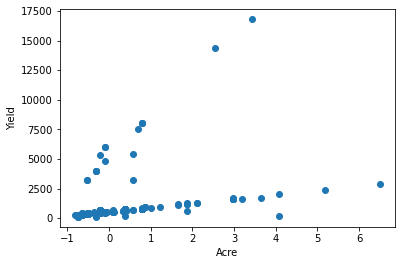

In [212]:
plt.scatter(f["Acre"],f['Yield'])
plt.xlabel("Acre")
plt.ylabel('Yield')
plt.show()

## --> Here we see 2 linear tendencies
## Let's check the second 'outlier' linear tendency

In [213]:
h = X[X['Yield']>5000]
h

,ID,CropTillageDepth,SeedlingsPerPit,TransIrriCost,StandingWater,CropOrgFYM,NoFertilizerAppln,BasalDAP,BasalUrea,1tdUrea,2tdUrea,Harv_hand_rent,Residue_length,Acre,Yield,Block_Chehrakala,Block_Garoul,Block_Gurua,Block_Jamui,Block_Khaira,Block_Mahua,Block_Noorsarai,Block_Rajgir,Block_Wazirganj,CropEstMethod_Broadcasting,CropEstMethod_LineSowingAfterTillage,CropEstMethod_Manual_PuddledLine,CropEstMethod_Manual_PuddledRandom,TransplantingIrrigationSource_Boring,TransplantingIrrigationSource_Canal,TransplantingIrrigationSource_Pond,TransplantingIrrigationSource_Rainfed,TransplantingIrrigationSource_TubeWell,TransplantingIrrigationSource_Well,TransplantingIrrigationPowerSource_Diesel,TransplantingIrrigationPowerSource_Electric,TransplantingIrrigationPowerSource_Solar,PCropSolidOrgFertAppMethod_Broadcasting,PCropSolidOrgFertAppMethod_RootApplication,PCropSolidOrgFertAppMethod_SoilApplied,PCropSolidOrgFertAppMethod_Spray,MineralFertAppMethod_Broadcasting,MineralFertAppMethod_RootApplication,MineralFertAppMethod_SoilApplied,Harv_method_hand,Harv_method_machine,Threshing_method_hand,Threshing_method_machine
521,ID_T2LOCPFM5WTE,-0.431082,0.181935,0.380427,-0.655139,-0.096314,-0.290751,0.702373,0.867649,-0.095320,-0.475738,-0.214039,0.151034,-0.097147,6000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
764,ID_12YY9WCJI5WH,0.451610,0.318261,2.235524,-0.562269,-0.096314,-0.290751,-0.096489,-0.251618,-0.206197,-0.475738,1.781172,-0.162204,3.418093,16800,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
842,ID_HSWMG2UG1PDM,-0.431082,0.181935,1.175469,-1.026621,-0.096314,-0.290751,0.702373,0.867649,-0.317074,-0.475738,0.058035,-0.162204,0.781663,8000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1618,ID_8HVG9OISAZS7,1.334303,-0.090719,-0.441116,-0.562269,-0.096314,-0.290751,-0.096489,-0.760376,-0.206197,-0.475738,-0.123347,-1.415156,-0.206998,5300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1936,ID_QQ9YPPNOUCAX,-0.431082,0.181935,-0.149600,-1.026621,-0.096314,-0.290751,0.017635,0.257140,0.569942,-0.475738,0.647530,-0.475442,2.539283,14400,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1986,ID_BUF2BI1W8Q5M,0.451610,-0.090719,-0.547121,0.366437,-0.096314,-0.290751,0.474127,0.664146,2.233098,-0.475738,0.783567,-0.162204,0.699274,7510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2270,ID_7I9Y27WN8YHO,-0.431082,0.181935,0.380427,-1.026621,-0.096314,-0.290751,0.474127,0.664146,-0.427951,-0.475738,-0.259385,-0.162204,-0.097147,6000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2605,ID_MQ1C4FZFKGSQ,-0.431082,0.181935,1.175469,-1.026621,-0.096314,-0.290751,0.702373,0.867649,-0.317074,-0.475738,-0.032656,0.151034,0.781663,8000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2762,ID_YBK5O8R6LB07,-0.431082,0.181935,1.440483,-1.026621,-0.096314,-0.290751,0.474127,0.664146,-0.317074,-0.475738,0.058035,-0.162204,0.781663,8000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2824,ID_EB3663FJ0LL7,-0.431082,0.181935,7.005774,-1.026621,-0.096314,-0.290751,0.017635,0.257140,-1.093213,-0.475738,0.148727,0.151034,0.561960,5400,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


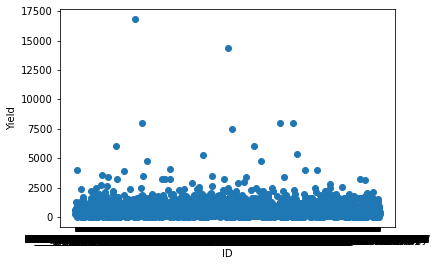

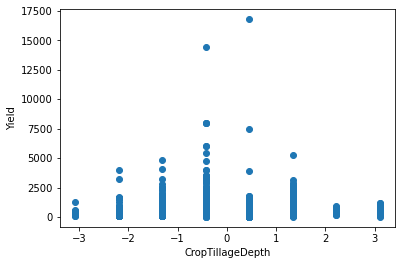

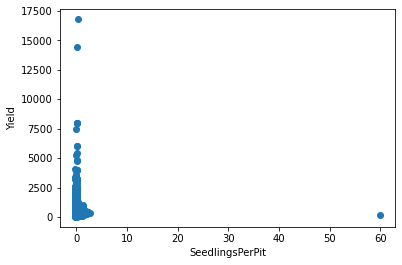

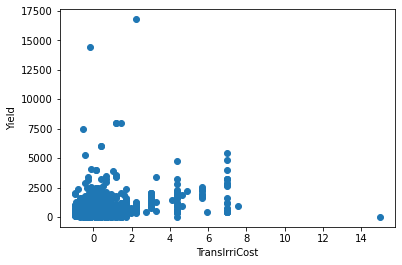

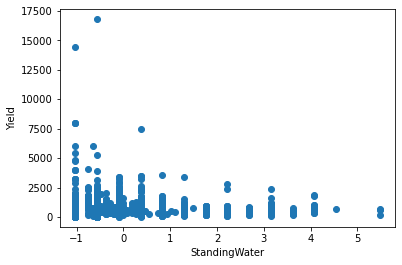

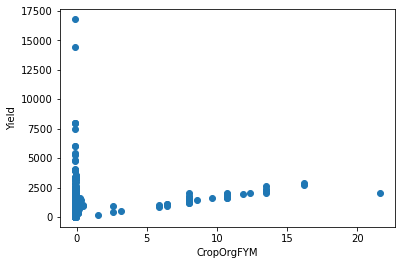

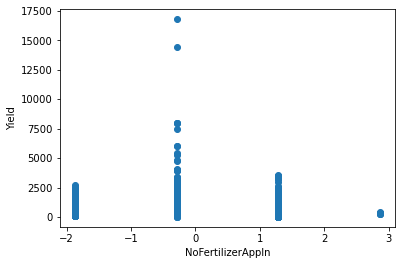

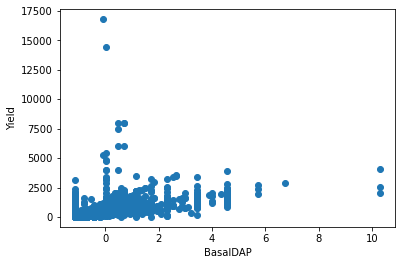

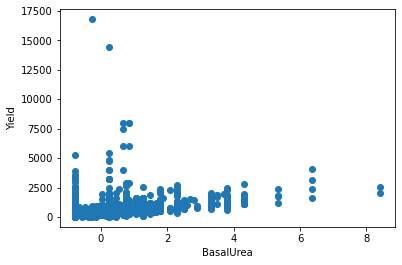

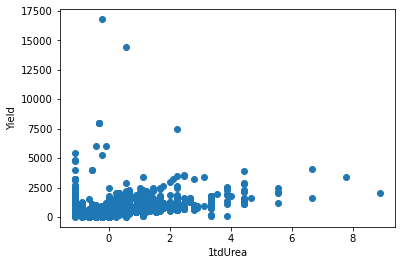

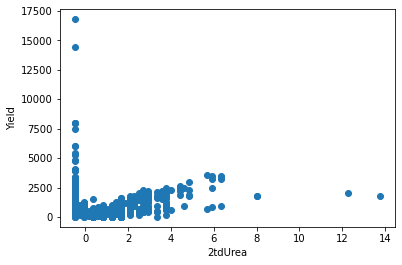

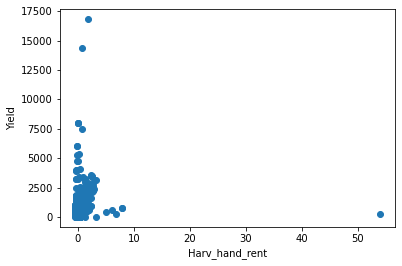

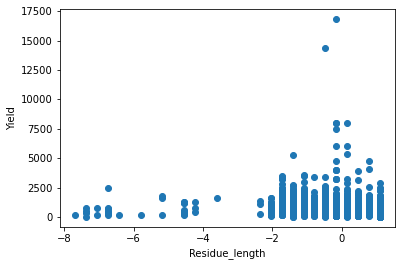

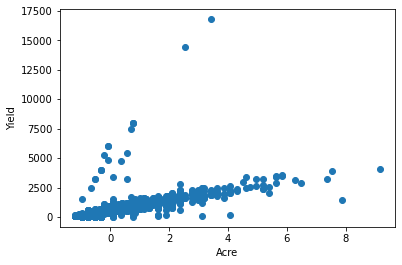

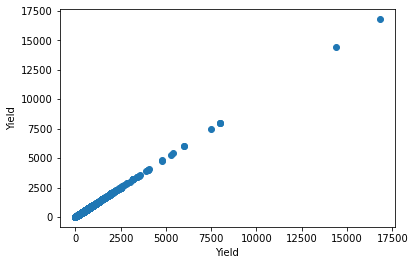

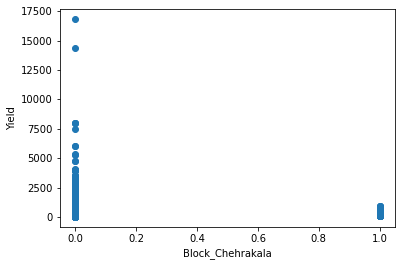

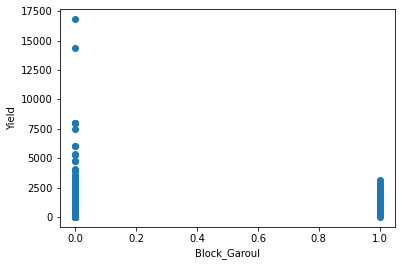

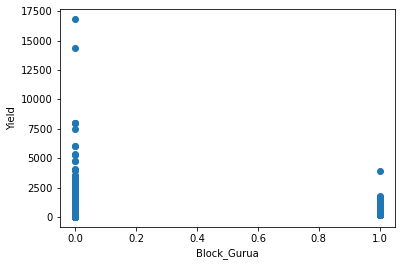

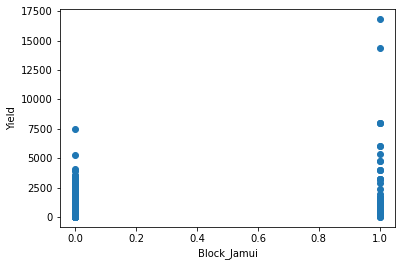

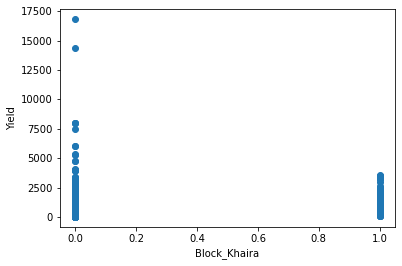

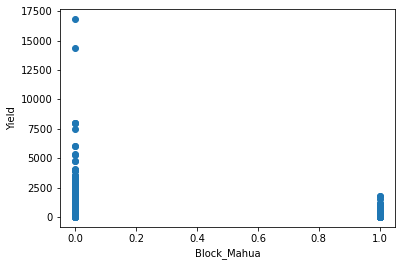

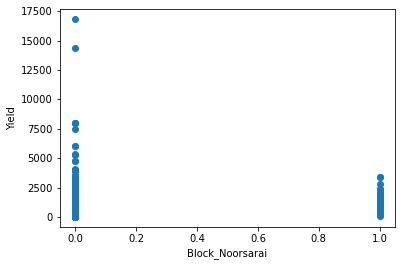

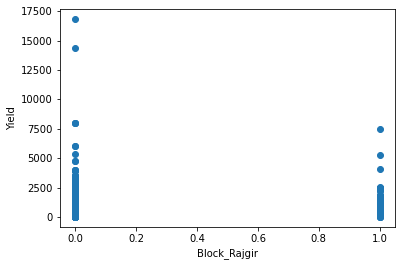

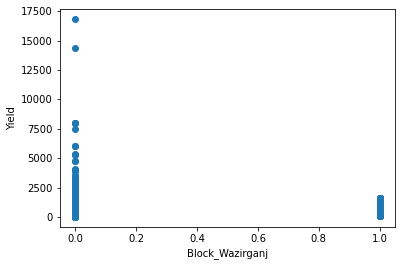

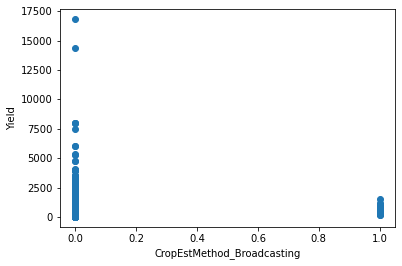

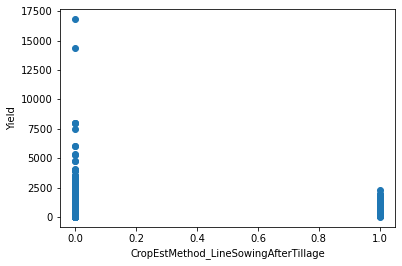

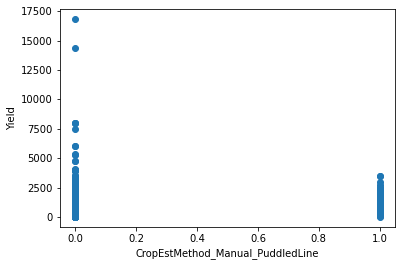

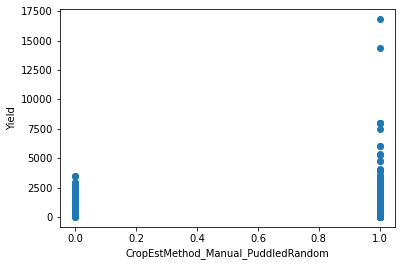

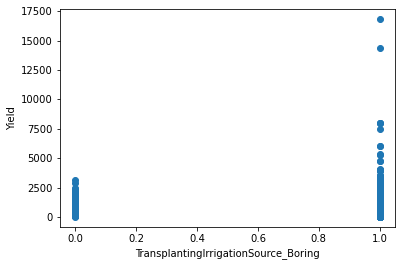

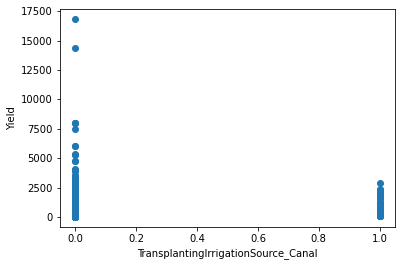

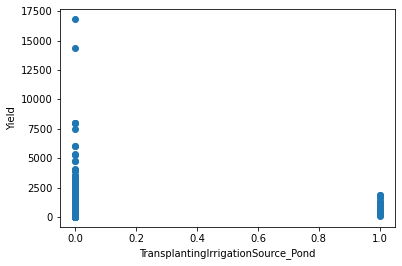

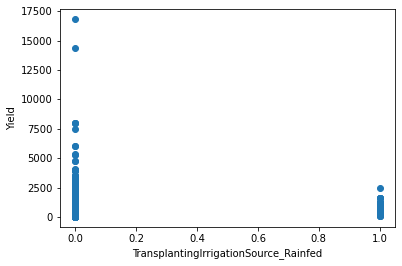

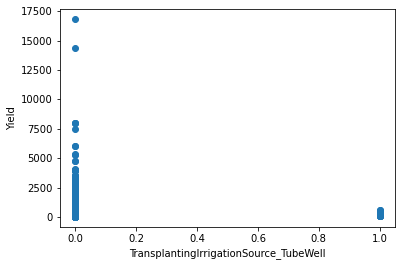

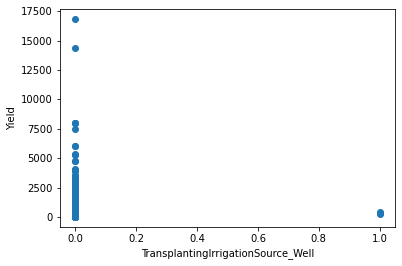

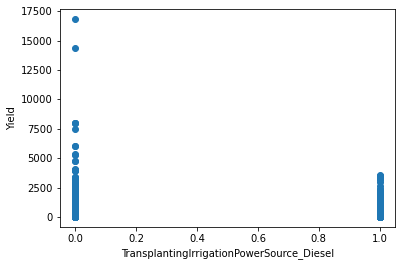

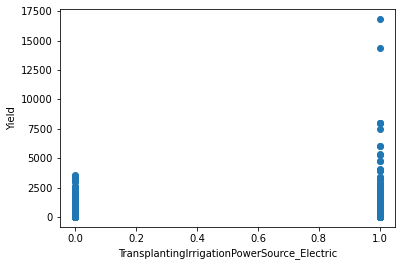

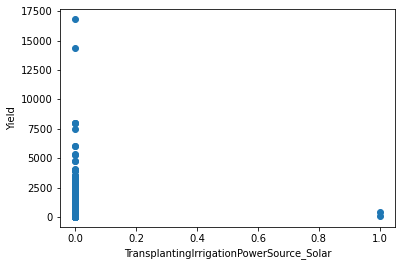

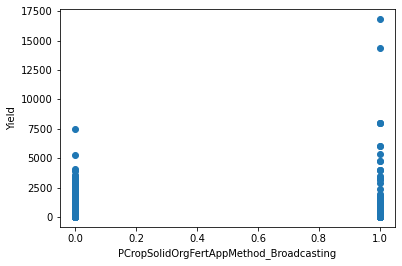

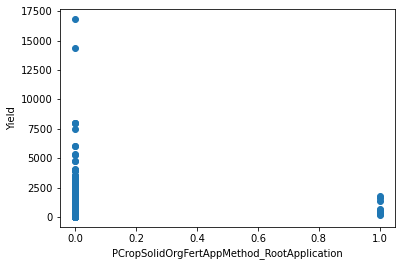

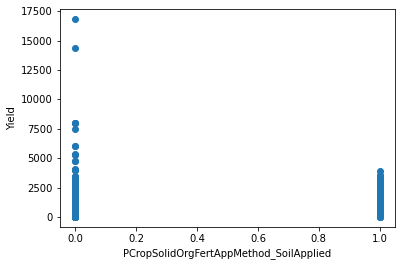

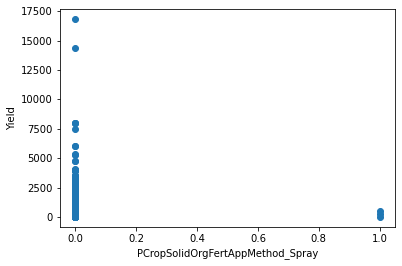

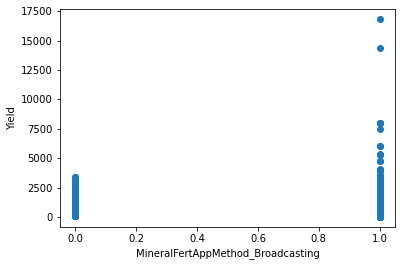

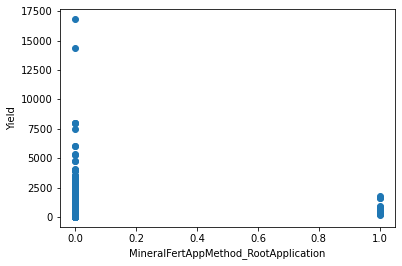

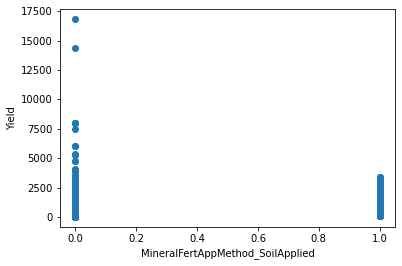

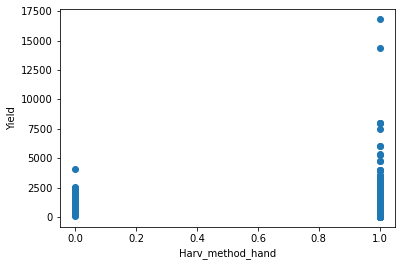

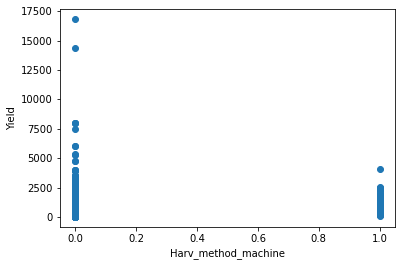

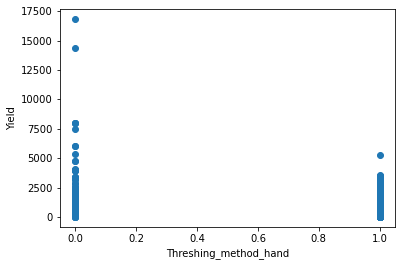

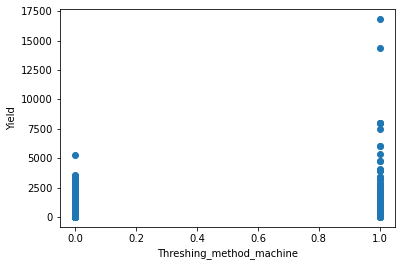

In [214]:
for col in X.columns:
    
    try:
        plt.scatter(X[col],X['Yield'])
        plt.xlabel(col)
        plt.ylabel('Yield')
        plt.show()
    finally:
        continue

# prep

In [215]:
df = X.copy()
df = df.drop(columns= ['ID'])
y = df.pop('Yield')


In [216]:

dft = Xt.copy()
idd = dft.pop('ID')


In [217]:
df

,CropTillageDepth,SeedlingsPerPit,TransIrriCost,StandingWater,CropOrgFYM,NoFertilizerAppln,BasalDAP,BasalUrea,1tdUrea,2tdUrea,Harv_hand_rent,Residue_length,Acre,Block_Chehrakala,Block_Garoul,Block_Gurua,Block_Jamui,Block_Khaira,Block_Mahua,Block_Noorsarai,Block_Rajgir,Block_Wazirganj,CropEstMethod_Broadcasting,CropEstMethod_LineSowingAfterTillage,CropEstMethod_Manual_PuddledLine,CropEstMethod_Manual_PuddledRandom,TransplantingIrrigationSource_Boring,TransplantingIrrigationSource_Canal,TransplantingIrrigationSource_Pond,TransplantingIrrigationSource_Rainfed,TransplantingIrrigationSource_TubeWell,TransplantingIrrigationSource_Well,TransplantingIrrigationPowerSource_Diesel,TransplantingIrrigationPowerSource_Electric,TransplantingIrrigationPowerSource_Solar,PCropSolidOrgFertAppMethod_Broadcasting,PCropSolidOrgFertAppMethod_RootApplication,PCropSolidOrgFertAppMethod_SoilApplied,PCropSolidOrgFertAppMethod_Spray,MineralFertAppMethod_Broadcasting,MineralFertAppMethod_RootApplication,MineralFertAppMethod_SoilApplied,Harv_method_hand,Harv_method_machine,Threshing_method_hand,Threshing_method_machine
0,0.451610,-0.090719,-0.414614,-0.562269,-0.096314,-0.290751,-1.123597,1.274656,0.569942,-0.475738,-0.123347,1.090748,0.095092,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.451610,-0.090719,-0.613375,-0.097916,-0.096314,-0.290751,0.588250,0.257140,1.124328,-0.475738,-0.483392,-0.788680,0.095092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.334303,-0.090719,-0.732631,-0.562269,-0.090889,-0.290751,-0.667104,-0.760376,-0.538828,-0.475738,-0.050794,1.090748,-0.699295,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,1.334303,-0.090719,-0.457016,-0.283657,-0.096314,-0.290751,-0.438858,-0.455122,-0.538828,-0.475738,-0.268454,-0.162204,-0.341261,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.431082,-0.090719,-0.149600,-0.562269,-0.096314,-0.290751,0.588250,2.292172,2.233098,-0.475738,-0.316520,-0.788680,0.850320,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865,1.334303,0.018342,0.009408,0.830790,-0.096314,-0.290751,0.930620,0.460643,0.237311,-0.475738,0.103381,-0.475442,0.397183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3866,0.451610,-0.227046,0.168416,-0.097916,-0.096314,1.285169,-0.438858,-0.760376,-0.427951,0.797943,-0.482485,1.090748,-0.756255,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3867,0.451610,-0.227046,-0.626625,0.830790,-0.096314,-1.866671,-1.123597,1.681662,-1.093213,-0.475738,0.602184,-0.475442,0.397183,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3868,-1.313775,0.181935,-0.202603,2.688201,-0.096314,-1.866671,-0.324735,0.257140,-1.093213,-0.475738,-0.395422,-0.475442,-0.316850,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


# XGBOOST

In [218]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import cross_val_score, KFold


regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)  # 'reg:squarederror' for regression tasks

# Set up cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=1)  # Adjust the number of splits as needed

# Perform cross-validation
scores = cross_val_score(regressor, df, y, cv=cv, scoring='neg_mean_squared_error')  # Using negative mean squared error

# Convert scores to positive and calculate root mean squared error (RMSE)
rmse_scores = np.sqrt(-scores)

# Display the results
print("Cross-Validation RMSE Scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))


Cross-Validation RMSE Scores: [505.57284677 723.86770891 361.75244189 501.12967199 558.89008007]
Mean RMSE: 530.2425499262149


# Linear Regression

In [219]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression



# Set up cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=252)

# Create a linear regression model
model = LinearRegression()

# Perform cross-validation
scores = cross_val_score(model, df, y, cv=cv, scoring='neg_mean_squared_error')

# Convert scores to positive and calculate root mean squared error (RMSE)
rmse_scores = np.sqrt(-scores)

# Display the results
print("Cross-Validation RMSE Scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))


Cross-Validation RMSE Scores: [341.14838116 524.56488493 497.5404735  386.02575835 612.87740919]
Mean RMSE: 472.4313814235855


# Huber Regression

In [220]:
from sklearn.linear_model import HuberRegressor

huber = HuberRegressor()

cv_scores = cross_val_score(huber, df, y, cv=5, scoring='neg_mean_squared_error')

# Display the cross-validation scores
print("Cross-Validation Scores (Negative Mean Squared Error):")
print(np.sqrt(-cv_scores))

# Calculate the mean cross-validation score
mean_cv_score = np.sqrt(-np.mean(cv_scores))
print(f"\nMean Cross-Validation Score: {mean_cv_score:.2f}")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterati

Cross-Validation Scores (Negative Mean Squared Error):
[617.21639404 361.9287907  596.57464274 498.96061778 167.81427535]

Mean Cross-Validation Score: 478.53


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


# Ransac Regression

In [221]:
from sklearn.linear_model import RANSACRegressor


ransac = RANSACRegressor()

# Perform cross-validation
cv_scores = cross_val_score(ransac, df, y, cv=5, scoring='neg_mean_squared_error')

# Display the cross-validation scores
print("Cross-Validation Scores (Negative Mean Squared Error):")
print(np.sqrt(-cv_scores))

# Calculate the mean cross-validation score
mean_cv_score = np.sqrt(-np.mean(cv_scores))
print(f"\nMean Cross-Validation Score: {mean_cv_score:.2f}")

Cross-Validation Scores (Negative Mean Squared Error):
[626.51957841 364.08768105 602.40768333 502.17750576 601.29827977]

Mean Cross-Validation Score: 548.04


# SVM

In [222]:
from sklearn.svm import SVR


svm_regressor = SVR(kernel='linear')

# Perform cross-validation
cv_scores = cross_val_score(svm_regressor, df, y, cv=5, scoring='neg_mean_squared_error')

print("Cross-Validation Scores (Negative Mean Squared Error):")
print(np.sqrt(-cv_scores))

# Calculate the mean cross-validation score
mean_cv_score = np.sqrt(-np.mean(cv_scores))
print(f"\nMean Cross-Validation Score: {mean_cv_score:.2f}")

Cross-Validation Scores (Negative Mean Squared Error):
[621.53823376 363.77870438 601.78747296 499.39106559 171.47471316]

Mean Cross-Validation Score: 481.58


# LGBM

In [223]:
!pip install lightgbm

In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3870 entries, 0 to 3869
Data columns (total 46 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   CropTillageDepth                             3870 non-null   float64
 1   SeedlingsPerPit                              3870 non-null   float64
 2   TransIrriCost                                3870 non-null   float64
 3   StandingWater                                3870 non-null   float64
 4   CropOrgFYM                                   3870 non-null   float64
 5   NoFertilizerAppln                            3870 non-null   float64
 6   BasalDAP                                     3870 non-null   float64
 7   BasalUrea                                    3870 non-null   float64
 8   1tdUrea                                      3870 non-null   float64
 9   2tdUrea                                      3870 non-null   float64
 10  

In [225]:
import lightgbm as lgb

hyper_params = {
    'objective': 'regression',
    'metric': 'rmse',  # Mean Squared Error
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'num_iterations': 100
    
} 
lgb_regressor = lgb.LGBMRegressor(**hyper_params, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(lgb_regressor, df, y, cv=5, scoring='neg_mean_squared_error')

# Display the cross-validation scores
print("Cross-Validation Scores (Negative Mean Squared Error):")
print(np.sqrt(-cv_scores))

# Calculate the mean cross-validation score
mean_cv_score = np.mean(np.sqrt(-cv_scores))
print(f"\nMean Cross-Validation Score: {mean_cv_score:.2f}")

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 3096, number of used features: 40
[LightGBM] [Info] Start training from score 597.899871
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current va

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 3096, number of used features: 40
[LightGBM] [Info] Start training from score 594.127261
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current va

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Cross-Validation Scores (Negative Mean Squared Error):
[630.15765062 325.84666613 615.12977262 454.53750519 200.30619176]

Mean Cross-Validation Score: 445.20


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 3870, number of used features: 40
[LightGBM] [Info] Start training from score 594.269251


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

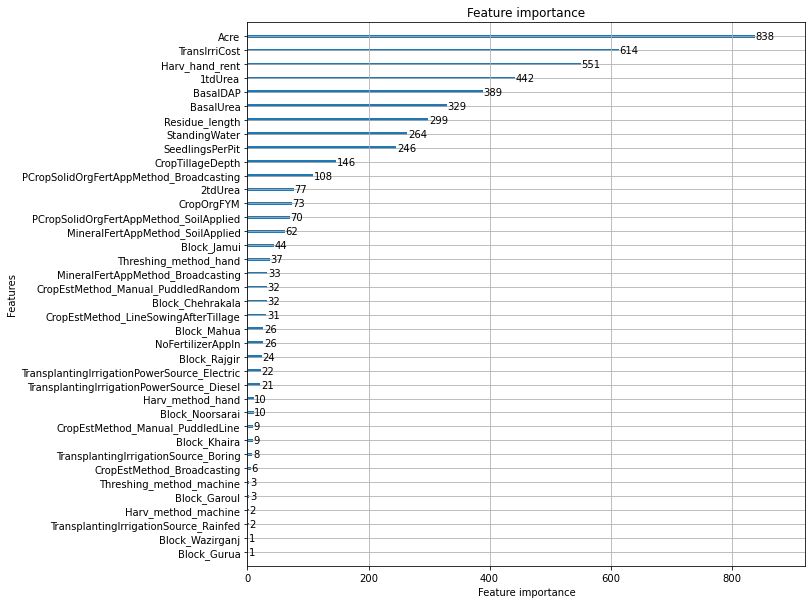

In [226]:
lgb_regressor.fit(df,y)
lgb.plot_importance(lgb_regressor, figsize=(10,10))

## I chose to use LGBM as a model (we could also use a ensemble containing different models)

In [227]:

pred = lgb_regressor.predict(dft)
pred

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


array([721.18400609, 413.86122495, 425.26400965, ..., 245.32767513,
       370.04837769, 312.19713168])

In [228]:
pred = pd.DataFrame(pred,columns=['Yield'])
pred.insert(0, "ID", idd)
pred

,ID,Yield
0,ID_F9XXEXN2ADR2,721.184006
1,ID_SO3VW2X4QO93,413.861225
2,ID_UKUQ7JM8E894,425.264010
3,ID_QUISMWEZR2H4,287.100319
4,ID_25JGI455VKCZ,528.224680
...,...,...
1285,ID_6MMECMX3B728,1122.518887
1286,ID_GZ9YGWCLLMKN,396.793969
1287,ID_01YVA2LJVYBR,245.327675
1288,ID_YQRL2IOUU4SZ,370.048378


In [229]:
pred.to_csv("gg.csv",index=False)